In [1]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
import datetime


Using TensorFlow backend.


In [2]:
from numpy.random import seed
seed(1)

In [3]:
base_model=MobileNet(weights='imagenet',include_top=False) #imports the mobilenet model and discards the last 1000 neuron layer.

x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(len(os.listdir('train')),activation='softmax')(x) #final layer with softmax activation

c:\users\oskar.wilhelmsson\appdata\local\programs\python\python36\lib\site-packages\keras_applications\mobilenet.py:208: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


In [4]:
model=Model(inputs=base_model.input,outputs=preds)
#specify the inputs
#specify the outputs
#now a model has been created based on our architecture

In [5]:
for layer in model.layers[:20]:
    layer.trainable=False
for layer in model.layers[20:]:
    layer.trainable=True

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=
                                 preprocess_input,
                                 #rotation_range=20,
                                 #brightness_range =(1, 5),
                                 #vertical_flip=True,
                                 validation_split=0.1
                                ) #included in our dependencies

train_generator=train_datagen.flow_from_directory('./train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                  subset='training'
                                                 )

validation_generator = train_datagen.flow_from_directory('./train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 subset='validation'
                                                 )

Found 18571 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.


In [8]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
# Adam optimizer
# loss function will be categorical cross entropy
# evaluation metric will be accuracy



from random import randint
UID = "".join([str(randint(0, 9)) for i in range(4)]).zfill(4)

def gen_model_temp_path(UID):

    date=datetime.datetime.now().strftime("%m-%d-%y_%H-%M-%S")
    folder = "/models/temp/"
    path = str(folder+UID+datetime.datetime.now().strftime("%m-%d-%y_%H-%M-%S")+".h5")
    if not os.path.exists(str(os.getcwd()+folder)):
        os.makedirs(str(os.getcwd()+folder))
    return str(os.getcwd()+path)    
    
earlyStop = EarlyStopping(monitor='val_loss', 
                          min_delta=0,
                          patience=12, #change this to something much lower
                          verbose=0, 
                          mode='auto')
checkpointer = ModelCheckpoint(filepath=gen_model_temp_path(UID),
                               verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

step_size_train=train_generator.n//train_generator.batch_size
history=model.fit_generator(generator=train_generator,
                   steps_per_epoch=train_generator.n//train_generator.batch_size,
                   validation_data=validation_generator,
                   validation_steps = validation_generator.n // validation_generator.batch_size,
                   epochs=30,
                   callbacks=[checkpointer,reduce_lr,earlyStop])

Epoch 1/30
1160/1160 [==============================] - 335s 289ms/step - loss: 3.4224 - acc: 0.1525 - val_loss: 2.9819 - val_acc: 0.2185

Epoch 00001: val_loss improved from inf to 2.98195, saving model to C:\Users\oskar.wilhelmsson\OneDrive - Acando AB\ViggeHack\transfer-learning/models/temp/728204-29-19_18-53-55.h5
Epoch 2/30
1160/1160 [==============================] - 322s 277ms/step - loss: 2.4765 - acc: 0.3059 - val_loss: 2.4043 - val_acc: 0.3532

Epoch 00002: val_loss improved from 2.98195 to 2.40428, saving model to C:\Users\oskar.wilhelmsson\OneDrive - Acando AB\ViggeHack\transfer-learning/models/temp/728204-29-19_18-53-55.h5
Epoch 3/30
1160/1160 [==============================] - 322s 278ms/step - loss: 2.0155 - acc: 0.4096 - val_loss: 2.2518 - val_acc: 0.3783

Epoch 00003: val_loss improved from 2.40428 to 2.25177, saving model to C:\Users\oskar.wilhelmsson\OneDrive - Acando AB\ViggeHack\transfer-learning/models/temp/728204-29-19_18-53-55.h5
Epoch 4/30
1160/1160 [==========

In [10]:
import pickle

In [11]:
#get dict of class names:
#model.class_indices
a = train_generator.class_indices.keys()
b = train_generator.class_indices.values()
a = [l[10:] for l in list(a)]
b=list(b)
name_id_map=dict(zip(b,a))
pickle.dump( name_id_map, open( "models/dict.p", "wb" ) )

In [12]:
model.save("models/model4.h5")

In [13]:
#see progress of fit

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


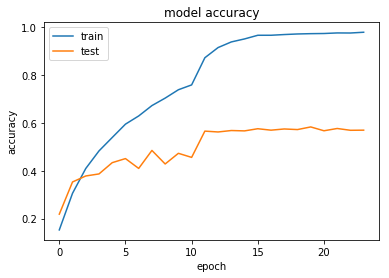

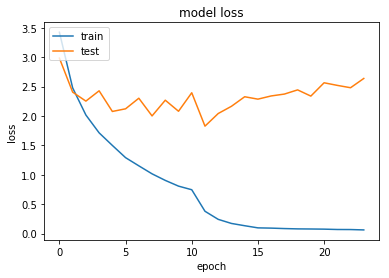

In [14]:
print(history.history.keys())
# summarize history for accuracy
f, ax = plt.subplots()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
f, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [6]:
import os
from keras.models import model_from_json
from keras import backend as K
import logging
import json
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing import image
from keras.models import load_model
from glob import glob
import pickle
import tensorflow as tf

logger = logging.getLogger('root')

class ParseJsonResult:
    def toJSON(self):
        return json.dumps(self,default=lambda o: o.__dict__, 
            sort_keys=True, indent=4)
    
class NeuralNetwork:
    def __init__(self,modelfile,classfile):
        self.session = tf.Session()
        self.graph = tf.get_default_graph()
        # the folder in which the model and weights are stored
        self.model_folder = 'models'
        self.modelfile = modelfile
        self.classfile =classfile
        # for some reason in a flask app the graph/session needs to be used in the init else it hangs on other threads
        self.load_mod()
        self.load_classes()
        
        
        
        with self.graph.as_default():
            with self.session.as_default():
                logging.info("neural network initialised")
                
        
    def load_mod(self):
        """
        :param file_name: [model_file_name]
        :return:
        """
        with self.graph.as_default():
            with self.session.as_default():
                try:
                    # load the model
                    self.model = load_model(os.path.join(self.model_folder, self.modelfile))
                        
                    logging.info("Neural Network loaded: ")
                    logging.info('\t' + "Neural Network model: " + self.modelfile)
                    return True
                except Exception as e:
                    logging.exception(e)
                    return False
    def load_classes(self):
        self.name_id_map = pickle.load(open(os.path.join(self.model_folder, self.classfile), "rb" ))
        
    def predict(self, input_img):
        with self.graph.as_default():
            with self.session.as_default():
                
                self.activations = np.round(np.squeeze(self.model.predict(np.expand_dims(preprocess_input(np.array(input_img)),axis=0))),2)
                print(self.model)
                df = pd.DataFrame(np.vstack((np.array(list(self.name_id_map.keys())).astype(int),np.array(list(self.name_id_map.values())))).T,columns=['idx','species'])
                df['activations'] = self.activations
                df = df.sort_values(by=['activations'],ascending=False)
                result = df.head(3)

                l = [ParseJsonResult()]*3

                for i,j in enumerate(result.iterrows()):
                    n,m = j
                    l[i] = ParseJsonResult()
                    l[i].idx = m.idx
                    l[i].species = m.species
                    l[i].activations = m.activations

                self.json = [l[i].toJSON() for i in range(len(l))]
                self.winner = json.loads(self.json[0])['species']

        return self.json

In [7]:
model = NeuralNetwork(modelfile = 'model4.h5',classfile = 'dict.p')

In [8]:
input_img=image.load_img("train/n02088094-Afghan_hound/n02088094_907.jpg")

In [9]:
model.predict(input_img)

['{\n    "activations": 0.8999999761581421,\n    "idx": "9",\n    "species": "Afghan_hound"\n}',
 '{\n    "activations": 0.07999999821186066,\n    "idx": "77",\n    "species": "komondor"\n}',
 '{\n    "activations": 0.009999999776482582,\n    "idx": "26",\n    "species": "Scottish_deerhound"\n}']

In [16]:
#evalute model

In [17]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns

In [18]:
#Evaluating using Keras model_evaluate:
x, y = zip(*(validation_generator[i] for i in range(len(validation_generator))))
x_test, y_test = np.vstack(x), np.vstack(y)
loss, acc = model.evaluate(x_test, y_test, batch_size=64)

print("Accuracy: " ,acc)
print("Loss: ", loss)


2009/2009 [==============================] - 13s 7ms/step
Accuracy:  0.5694375308726545
Loss:  2.569629324793875


In [19]:
y_pred = [np.argmax(model.predict(np.expand_dims(np.array(x_test[i]),axis=0))) for i in range (len(y_test))]

In [20]:
import matplotlib.pyplot as plt


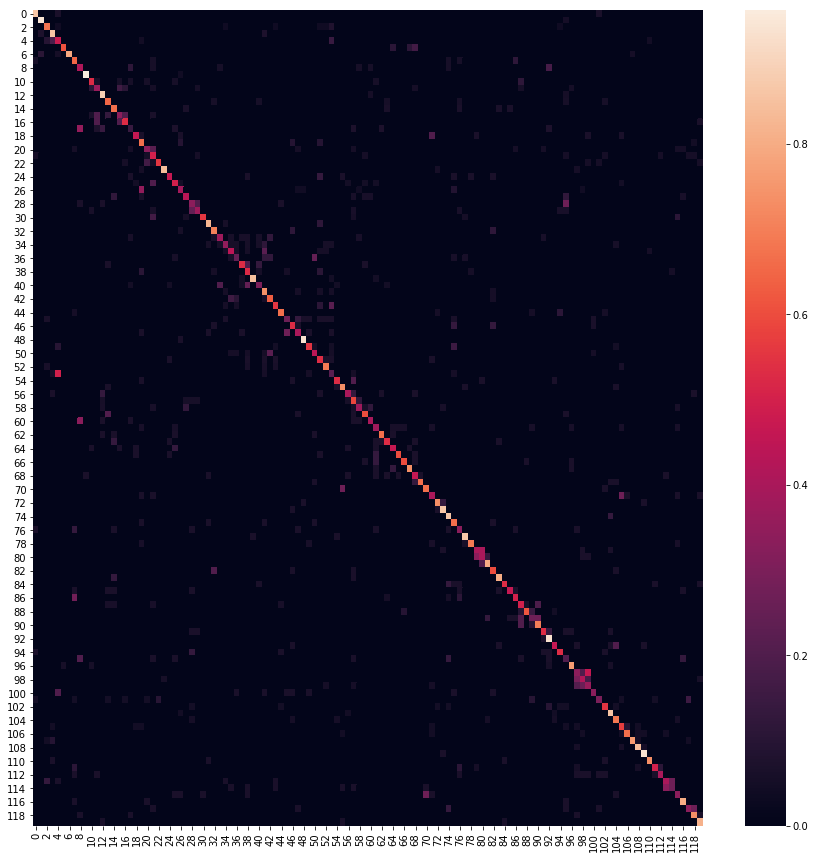

In [21]:
f,ax = plt.subplots(figsize=(15,15))
#sns.heatmap(confusion_matrix(y_test, y_pred).astype(np.float)/confusion_matrix(y_test, y_pred).sum(axis=1)[:, np.newaxis]
sns.heatmap((confusion_matrix(np.argmax(y_test,axis=1), y_pred).astype(np.float)/confusion_matrix(np.argmax(y_test,axis=1), y_pred).sum(axis=1)[:, np.newaxis]))

In [22]:
print(classification_report(np.argmax(y_test,axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79        15
           1       0.85      0.94      0.89        18
           2       0.71      0.68      0.69        25
           3       0.55      0.86      0.67        14
           4       0.36      0.48      0.41        21
           5       0.92      0.61      0.73        18
           6       1.00      0.79      0.88        19
           7       0.42      0.65      0.51        17
           8       0.32      0.41      0.36        17
           9       0.96      0.96      0.96        23
          10       0.60      0.53      0.56        17
          11       0.44      0.37      0.40        19
          12       0.62      0.89      0.73        18
          13       0.52      0.65      0.58        17
          14       0.50      0.67      0.57        15
          15       0.38      0.33      0.36        15
          16       0.53      0.53      0.53        15
          17       0.18    

In [69]:
#Look at images being generated:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input) #included in our dependencies
x=0
for i in train_datagen.flow_from_directory('./train/', # this is where you specify the path to the main data folder
                                                 target_size=(224,224),
                                                 color_mode='rgb',
                                                 #batch_size=16,
                                                 class_mode='categorical',
                                                 shuffle=True,
                                                 batch_size=1,
                                                 save_to_dir=path, 
                                                 save_prefix='test', 
                                                 save_format='jpg'):
    
    x=x+1
    if x>=3:
        break
    
        

Found 20580 images belonging to 120 classes.
